Want to show how the method would work with simple data.

In [2]:
%matplotlib inline
from astropy.convolution import convolve
from prettyplots.prettyplots import percentiles_to_errors
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
from scipy.interpolate import griddata
from imgcube.cube import imagecube
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('paper')

In [3]:
# Read in cube.
cube = imagecube('../data/cont/TWHya.230GHz.fits', clip=1.2)

In [4]:
# Load up the MAP model to fake the data.
Tb = np.load('../models/B6c_MAP.npy')
Tb[1] = np.max([np.zeros(Tb[0].size), Tb[1] - Tb[1, -1]], axis=0) * 1e3
Tb = interp1d(Tb[0], Tb[1], bounds_error=False, fill_value='extrapolate')

In [5]:
# Sky coordinates.
x_sky, y_sky = np.meshgrid(cube.xaxis, cube.yaxis)
r_sky, t_sky = np.hypot(x_sky, y_sky), np.arctan2(y_sky, x_sky)

In [6]:
# Make the models.
r0, t0, _ = cube.disk_coords(x0=2.19546669e-03, y0=9.29874145e-03, inc=6.79276166, PA=179.3)
r1, t1, _ = cube.disk_coords(x0=2.19546669e-03, y0=9.29874145e-03, inc=6.79276166, PA=151.0)
model = convolve(Tb(r0), cube._beamkernel(), boundary='wrap')
model = cube.data * 1e3

In [7]:
# Deproject the coordinates.
rgrid = np.linspace(0, 1.2, 200)
tgrid = np.linspace(-np.pi, np.pi, 180)

obs0 = griddata((r0.flatten(), t0.flatten()), model.flatten(),
                (rgrid[None, :], tgrid[:, None]), method='nearest')
obs1 = griddata((r1.flatten(), t1.flatten()), model.flatten(),
                (rgrid[None, :], tgrid[:, None]), method='nearest')

(0.06069150194526, 0.93930849805474)

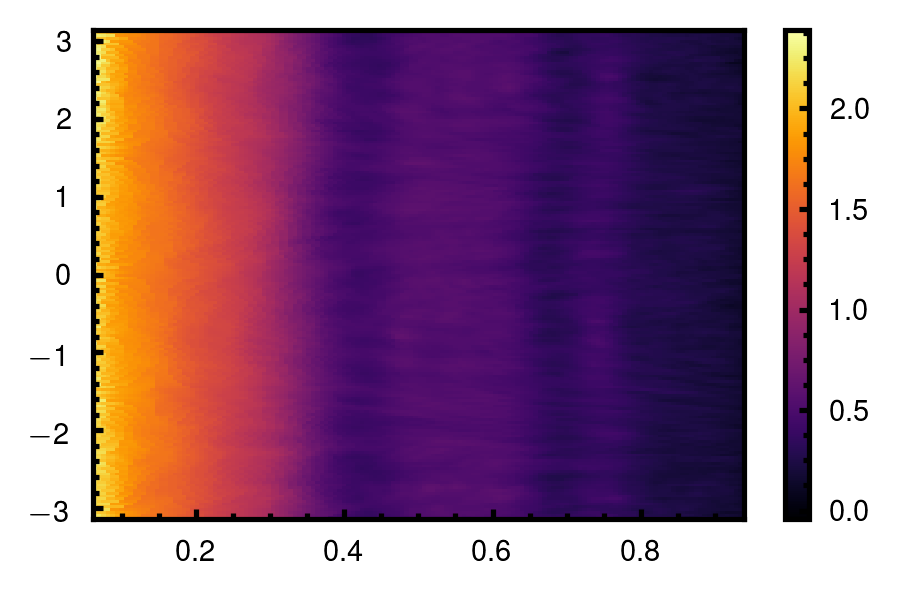

In [8]:
fig, ax = plt.subplots()
im = ax.imshow(obs0, origin='lower', aspect='auto', cmap='inferno',
               extent=[rgrid[0], rgrid[-1], tgrid[0], tgrid[-1]])
plt.colorbar(im)
ax.set_xlim(cube.bmaj, 1.0 - cube.bmaj)

Text(0.98,0.9,'Deprojected with incorrect inclination.')

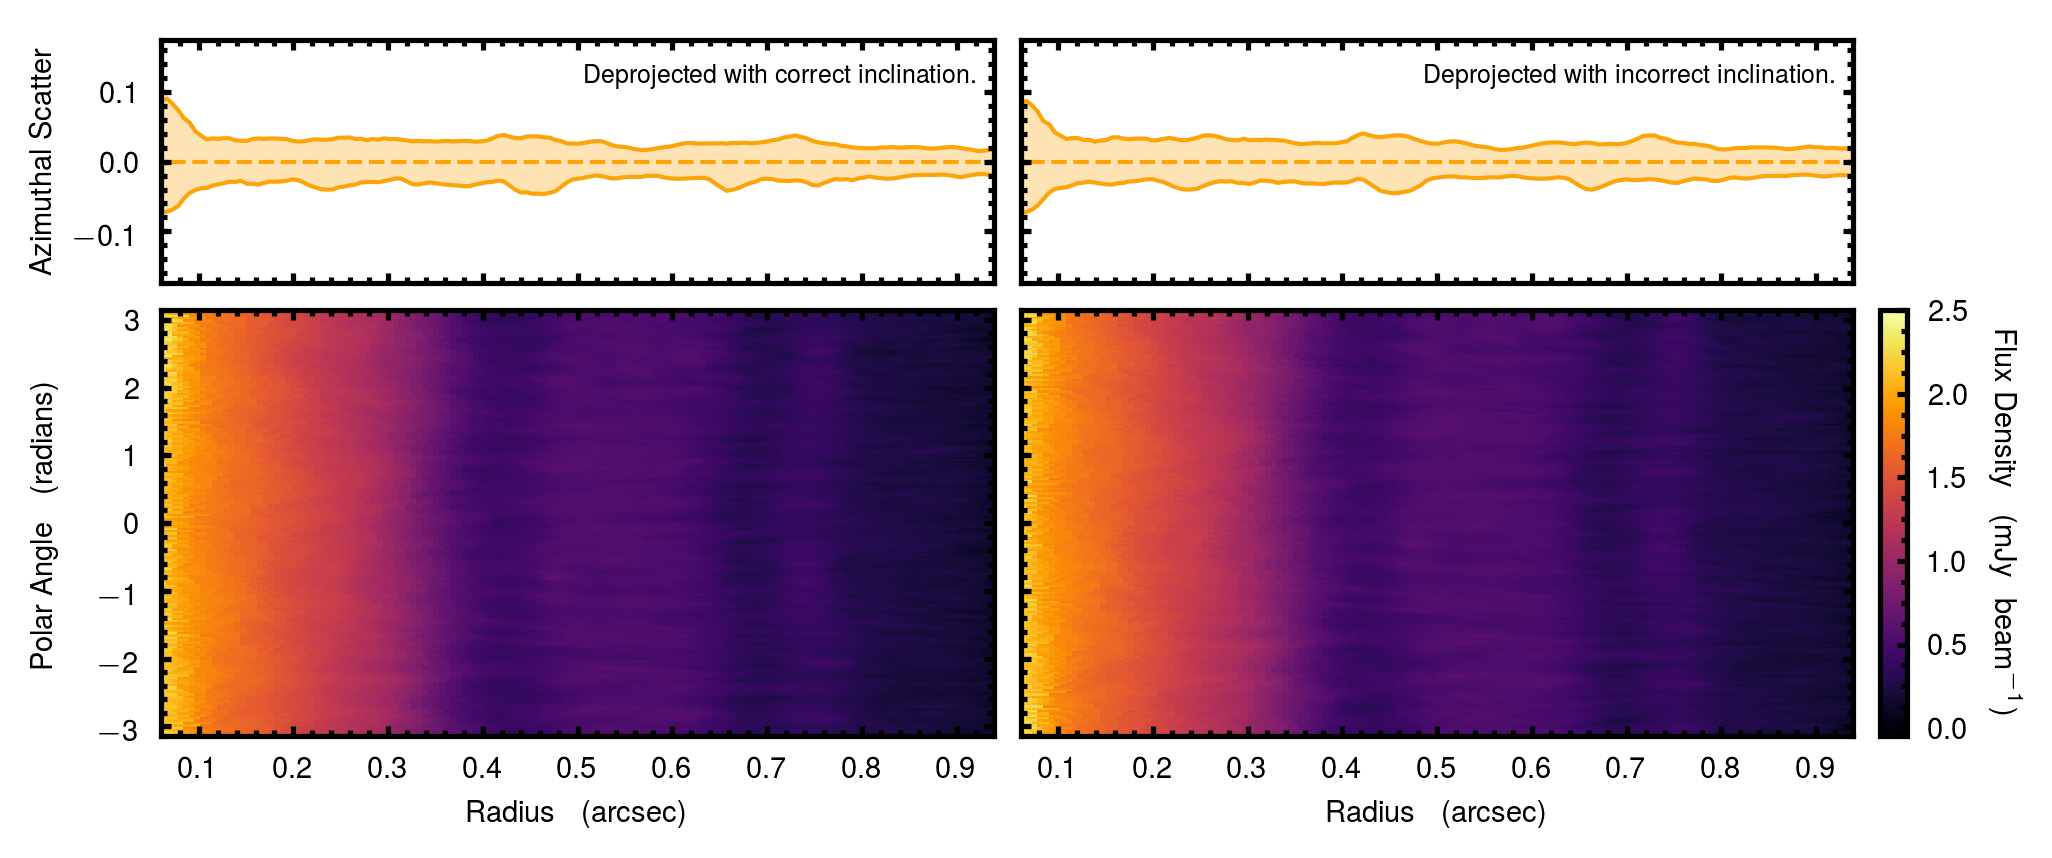

In [9]:
fig = plt.figure(figsize=(6.0, 2.5))
aspect = fig.get_figwidth() / fig.get_figheight()

# Set the spacing.

dx = 0.015
dy = dx * aspect
x_cbar = 1.0 * dx
ratio = 1.75

# Get the other values.

y = (1.0 - 3. * dy) / (1. + 1. / ratio)
x = (1.0 - 4. * dx - x_cbar) / 2.0

# Make the grid.

gs = gridspec.GridSpec(1, 1)
gs.update(left=dx, right=dx+x, top=1.0-dy, bottom=1.0-dy-y/ratio)
ax1 = plt.subplot(gs[0, 0])

gs = gridspec.GridSpec(1, 1)
gs.update(left=dx, right=dx+x, top=dy+y, bottom=dy)
ax2 = plt.subplot(gs[0, 0])

gs = gridspec.GridSpec(1, 1)
gs.update(left=2*dx+x, right=2*dx+2*x, top=1.0-dy, bottom=1.0-dy-y/ratio)
ax3 = plt.subplot(gs[0, 0])

gs = gridspec.GridSpec(1, 1)
gs.update(left=2*dx+x, right=2*dx+2*x, top=dy+y, bottom=dy)
ax4 = plt.subplot(gs[0, 0])

gs = gridspec.GridSpec(1, 1)
gs.update(left=3*dx+2*x, right=3*dx+2*x+x_cbar, top=1.0-dy, bottom=1.0-dy-y/ratio)
ax5 = plt.subplot(gs[0, 0])
ax5.axis('off')

gs = gridspec.GridSpec(1, 1)
gs.update(left=3*dx+2*x, right=3*dx+2*x+x_cbar, top=dy+y, bottom=dy)
ax6 = plt.subplot(gs[0, 0])

# Plot the data.

pcnts = np.nanpercentile(obs0, [16, 50, 84], axis=0)
pcnts = np.array([np.convolve(p, [0.33, 0.33, 0.33], mode='same') for p in pcnts])
l = ax1.plot(rgrid, np.zeros(rgrid.size), color=cm.inferno(0.8), lw=1.0, ls='--')
ax1.fill_between(rgrid, pcnts[0] - pcnts[1], pcnts[2] - pcnts[1],
                facecolor=l[0].get_color(), lw=0.0, alpha=0.3)
ax1.fill_between(rgrid, pcnts[0] - pcnts[1], pcnts[2] - pcnts[1],
                edgecolor=l[0].get_color(), lw=1.0, facecolor='none')
ax1.set_ylabel('Azimuthal Scatter')


#ax1.text(-0.02, 0.5, 'Normalized Scatter', fontsize=6, ha='right',
#         va='center', rotation=90, transform=ax1.transAxes)



im = ax2.imshow(obs0, origin='lower', aspect='auto', cmap='inferno',
                extent=[rgrid[0], rgrid[-1], tgrid[0], tgrid[-1]], vmax=2.5)
ax2.set_ylabel('Polar Angle \,\, (radians)')
ax2.set_xlabel('Radius \,\, (arcsec)')

pcnts = np.nanpercentile(obs1, [16, 50, 84], axis=0)
pcnts = np.array([np.convolve(p, [0.33, 0.33, 0.33], mode='same') for p in pcnts])
l = ax3.plot(rgrid, np.zeros(rgrid.size), color=cm.inferno(0.8), lw=1.0, ls='--')
ax3.fill_between(rgrid, pcnts[0] - pcnts[1], pcnts[2] - pcnts[1],
                facecolor=l[0].get_color(), lw=0.0, alpha=0.3)
ax3.fill_between(rgrid, pcnts[0] - pcnts[1], pcnts[2] - pcnts[1],
                edgecolor=l[0].get_color(), lw=1.0, facecolor='none')
ax3.set_yticklabels([])

im = ax4.imshow(obs1, origin='lower', aspect='auto', cmap='inferno',
                extent=[rgrid[0], rgrid[-1], tgrid[0], tgrid[-1]], vmax=2.5)
ax4.set_yticklabels([])
ax4.set_xlabel('Radius \,\, (arcsec)')

cb = plt.colorbar(im, cax=ax6)
cb.set_label('Flux Density \,\, (mJy \, beam$^{-1}$)', rotation=270, labelpad=13)

for ax in [ax1, ax3]:
    ax.set_ylim(-1.75e-1, 1.75e-1)
    ax.set_xticklabels([])
for ax in [ax1, ax2, ax3, ax4]:
    ax.tick_params(which='both', right=1, top=1)
    ax.set_xlim(cube.bmaj, 1.0 - cube.bmaj)
fig.align_ylabels([ax1, ax2])

ax1.text(0.98, 0.9, 'Deprojected with correct inclination.', fontsize=6,
         ha='right', va='top', rotation=0, transform=ax1.transAxes)
ax3.text(0.98, 0.9, 'Deprojected with incorrect inclination.', fontsize=6,
         ha='right', va='top', rotation=0, transform=ax3.transAxes)

#plt.savefig('methodology.pdf', bbox_inches='tight')